In [1]:
from duckduckgo_search import DDGS
from fastdownload import download_url
from fastai.vision.all import *
import gradio
import cv2
import ipywidgets as widgets

In [3]:
# Source bear image links
bear_types = ['grizzly','black','teddy']
path = Path('bears')

if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = []
        with DDGS() as ddgs:
            keywords = f'{o} bear'
            ddgs_images_gen = ddgs.images(
                keywords,
                type_image = 'photo',
                max_results = 100
            )
            for r in ddgs_images_gen:
                results.append(r['image'])
        download_images(dest, urls=results)


In [4]:
# Check image files in folder
fns = get_image_files(path)
fns

(#264) [Path('bears/black/44d73bc3-bbc3-40d4-8cbb-8d5b4acc6be8.jpg'),Path('bears/black/13ffe4da-6980-4935-bf47-c41917f59bd8.jpg'),Path('bears/black/02d3c78d-f2ae-4d68-8237-b4af8e69f703.jpg'),Path('bears/black/4688fff2-0558-4aa0-b207-400f0e6797c9.jpg'),Path('bears/black/007d00e8-5764-43c5-84ec-c89481b87f28.jpg'),Path('bears/black/6caec244-00a5-4aef-9188-29ac44d4ef9b.jpg'),Path('bears/black/fd8d70d2-f7ca-4164-b76f-f5ead0133c88.jpg'),Path('bears/black/94a9e699-26d4-4d51-90a9-37c90feb867a.jpg'),Path('bears/black/9ecfb8e0-3994-435d-893f-0de6d6aaae8e.jpg'),Path('bears/black/3ab07ae7-4b90-4f8e-bf96-a80905951d4d.jpg')...]

In [5]:
# Verify failed images
failed = verify_images(fns)
failed

(#0) []

In [ ]:
# Remove failed images with unlink
failed.map(Path.unlink)

(#9) [None,None,None,None,None,None,None,None,None]

In [6]:
# Create dataloader for model
bears = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct = 0.2, seed = 42),
    get_y = parent_label,
    item_tfms = Resize(128)
)

In [7]:
#  Create training data for model using random resized crop and transforms
bears = bears.new(
    item_tfms = RandomResizedCrop(224, min_scale = 0.5),
    batch_tfms = aug_transforms()
)

dls = bears.dataloaders(path)

In [8]:
#  Create learner and fine tune it
learn = vision_learner(dls, resnet18, metrics = error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.440947,1.251863,0.403846,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.318936,0.358470,0.153846,00:07
1,0.259465,0.040547,0.000000,00:07
2,0.207487,0.022840,0.000000,00:07
3,0.180687,0.025792,0.000000,00:07


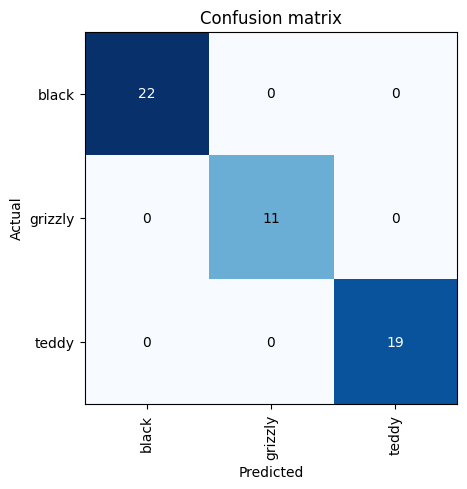

In [9]:
# Create confusion matrix to see effectiveness
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

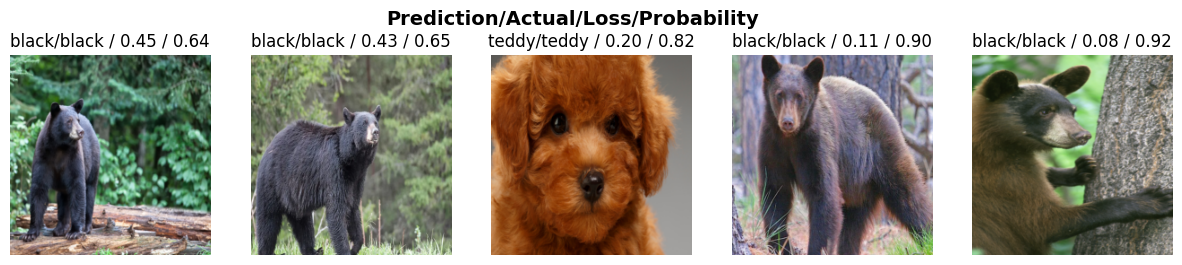

In [10]:
# Check images with the highest loss in the dataset
interp.plot_top_losses(5, nrows=1)

In [ ]:
# Code to clean incorrect data in the learning set
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
# Code to delete photos marked for deletion in the cleaner set
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()

# Code to move images to different categories marked in the data set
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [11]:
# Export model to a pkl file
learn.export()

In [3]:
# Check that export file exists
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [4]:
# Load model as an inference learner
learn_inf = load_learner(path/'export.pkl')

In [14]:
# Make a prediction on an image
learn_inf.predict('grizzly.jpeg')
# Returns predicted category, index of the predicted category, and the probabilities of each category

('grizzly', tensor(1), tensor([1.6806e-03, 9.9819e-01, 1.3169e-04]))

In [15]:
# Access dataloaders as an attribute of the inference model
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

In [6]:
# Grab the image
# For simplicity sake, just manually coding the image location so we don't have to click the button
btn_upload = SimpleNamespace(data = ['grizzly.jpeg'])

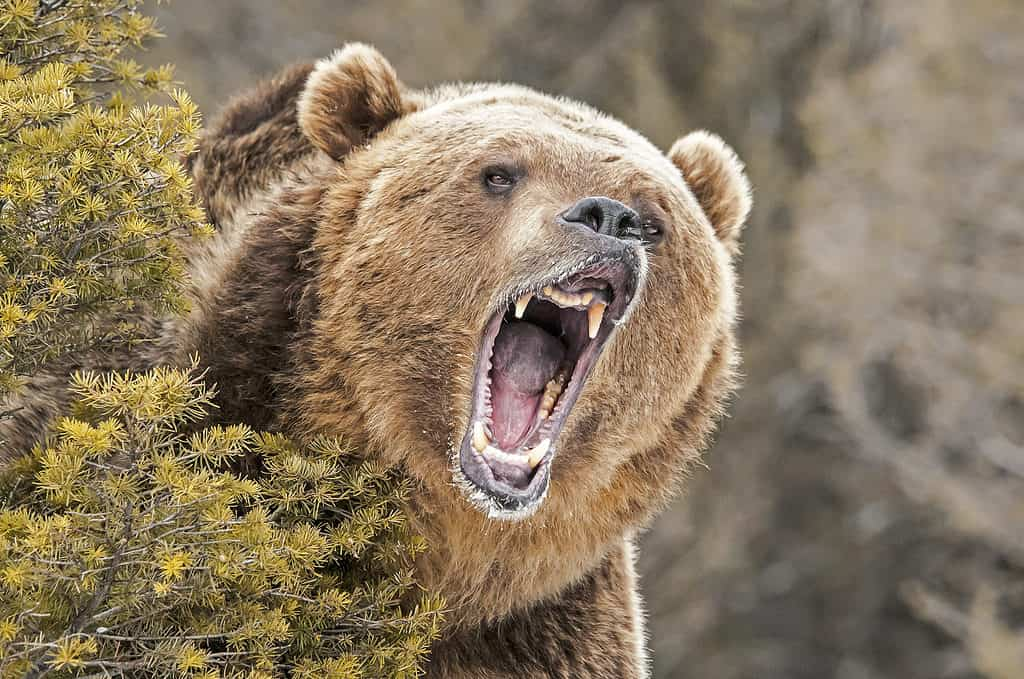

In [8]:
# Confirm image is there / show image
img = PILImage.create(btn_upload.data[-1])
img

In [9]:
# Use output widget to display photo
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [10]:
# Get predictions on image
pred,pred_idx,probs = learn_inf.predict(img)

In [11]:
# Use label widget to display predictions
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 0.9982')

In [12]:
# Use a button to run the classifier
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [13]:
# Create a click event handler to actually classify the image when the button is clicked
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred, pred_idx, probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [14]:
# Use ipywidgets to make a file upload button
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value=(), description='Upload')